# Eyes Open/Closed Detection

In this notebook we will train a model to determine whether a person's eyes are open or closed based on EEG signals from the Muse 2 headset.

## Running a Survey

First we can import our library and run a survey, so we can train a model on the resulting data. We'll ask the participant to first get into a comfortable position, then open eyes for 30s, close for 30s, etc. 3x.

In [8]:
%matplotlib notebook
# Reload external source files when they change
%load_ext autoreload
%autoreload 2
import sys
from datetime import timedelta
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
sys.path.append("../src")
from recorder import Muse2EEGRecorder
from survey import Survey

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [17]:
eyes_open_step = (timedelta(seconds=30), "eyes_open", "Please open your eyes.", True)
eyes_closed_step = (timedelta(seconds=30), "eyes_closed", "Please close your eyes.", True)
eyes_schedule = [
    (timedelta(seconds=30), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", False),
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step,
    eyes_open_step,
    eyes_closed_step
]

test_schedule = [
    (timedelta(seconds=5), "intro", "Just breathe normally, gently relax any tension, get in a comfortable position.", True)
]

muse2_recorder = Muse2EEGRecorder()
eyes_survey = Survey(muse2_recorder, "Eyes open-closed", "Eyes open for 30, closed for 30 - repeat 3x.", eyes_schedule)
eyes_survey.record("Alex")


    Error 305 for command:
        open "..\data\Meditation-bell-sound.mp3"
    Cannot specify extra characters after a string enclosed in quotation marks.

    Error 305 for command:
        close "..\data\Meditation-bell-sound.mp3"
    Cannot specify extra characters after a string enclosed in quotation marks.
Failed to close the file: "..\data\Meditation-bell-sound.mp3"


Next step -- Just breathe normally, gently relax any tension, get in a comfortable position.


PlaysoundException: 
    Error 305 for command:
        open "..\data\Meditation-bell-sound.mp3"
    Cannot specify extra characters after a string enclosed in quotation marks.

## Preparing Data for Learning

We need to transform our raw survey data into a format suitable for supervised learning. We will create an input tensor with the shape required by PyTorch - `(batch_size, kernel_size, seq_len)`, aka `(Samples, Variables, Length / time or sequence steps)`, or `[batch_size, channels, num_features (aka: H * W)]`.

1. Batch size can be tuned. We will start with `64`.
2. The second index is the number of features per batch. In this case, we have four EEG sensors, so that will be `4`.
3. The number of samples included for each feature in each batch. This must be the same for every batch, so we will need to use a size <= the size of the smallest dataset we will use.

The PyTorch `DataLoader` is an alternative to batching out data manually. After creating a `Dataset`, the DataLoader will batch data with a given batch size.

In [4]:
import os
import torch
from torch.utils.data import Dataset, DataLoader

from eeg_preprocessing import preprocess_eeg_channel
from eegdata import EEGSurveyDataset, ChunkedDataset, MultiDataset

def transform_normalize(data):
    for ch in range(data.shape[1]):
        data[:, ch] = preprocess_eeg_channel(data[:, ch])
        stddev = data[:, ch].std()
        if stddev != 0:
            data[:, ch] = (data[:, ch] - data[:, ch].mean()) / stddev
    return data

batch_size = 35

# Create PyTorch Datasets
# For 30s datasets, the # of samples is between 7666 and 7936, with 7936 being the most common.
ds1 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closedAlex2023-02-28 175124.152478", 7665, transform=transform_normalize)
ds2 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-02-28 180223.542443", 7665, transform=transform_normalize)
ds3 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-02-28 181123.180577", 7665, transform=transform_normalize)
ds4 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-02-28 182051.315931", 7665, transform=transform_normalize)
ds5 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-03-01 190129.939632", 7665, transform=transform_normalize)
ds6 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-03-01 190647.597127", 7665, transform=transform_normalize)
ds7 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-03-01 191102.296501", 7665, transform=transform_normalize)
ds8 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-03-01 191541.164491", 7665, transform=transform_normalize)
ds9 = EEGSurveyDataset("../data\muse2-recordings\surveys\Eyes open-closed Alex 2023-03-01 192625.791140", 7665, transform=transform_normalize)
ds1, ds2, ds3, ds4, ds5, ds6, ds7, ds8 = ChunkedDataset(ds1, batch_size), ChunkedDataset(ds2, batch_size), ChunkedDataset(ds3, batch_size), ChunkedDataset(ds4, batch_size), ChunkedDataset(ds5, batch_size), ChunkedDataset(ds6, batch_size), ChunkedDataset(ds7, batch_size), ChunkedDataset(ds8, batch_size)
train_dataset = MultiDataset([ds1, ds2, ds3, ds5, ds6, ds7])
test_dataset = MultiDataset([ds4, ds8])
# Create DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, num_workers=4)

## Evaluate Data Quality

Some

## PyTorch Model

Now we can create the neural network we will be training on the collected data. We will use the [simple keras model by Sentdex](https://github.com/Sentdex/BCI) as a starting point.

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F

n_channels = 4
n_outputs = 2

# Create model
net = nn.Sequential(
    # Pass input to a 1D convolutional layer with a kernel size of 3, apply to activation function.
    nn.Conv1d(n_channels, 32, 3),
    nn.ReLU(),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel.
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Pass previous layer output to a 1D convolutional layer with a kernel size of 2, apply to activation function,
    # and get the max value from each kernel. (same as previous layer)
    nn.Conv1d(32, 32, 2),
    nn.ReLU(),
    nn.MaxPool1d(kernel_size=2),

    # Flatten the convolutions. Input shape: (a, b, c), Output shape: (a, b*c)
    nn.Flatten(),
    
    #nn.Dropout(0.5),
    # ?
    # XXX: The first number needs to be updated each time the input shapes change. We could instead
    #      Create a class-based Module, and do a single pass through the conv portion of the network
    #      in order to determine the actual size.
    #      (This technique is shown in https://www.youtube.com/watch?v=1gQR24B3ISE&list=PLQVvvaa0QuDdeMyHEYc0gxFpYwHY2Qfdh&index=7).
    #      For now, we can update this value as needed by commenting out all layers after Flatten(), then running the code
    #      below and inspecting the output shape. The x[1] value should be the first arg in the following line.
    nn.Linear(1696, 512),  # ~= nn.LazyLinear(512)

    # Flatten the linear layer into the required number of outputs
    nn.Linear(512, n_outputs),
    nn.Softmax()
)

for i, data in enumerate(train_dataloader, 0):
    features, labels = data
    print("Model input shape:", features.shape)
    out = net(features.float())
    print("Model output shape:", out.shape)
    break

Model input shape: torch.Size([35, 4, 219])
Model output shape: torch.Size([35, 2])


c:\Users\amsb9\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\nn\modules\container.py:204: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  input = module(input)


### Training the model

100%|██████████| 80/80 [35:38<00:00, 26.73s/it]


Passes per epoch: 36.0
Final Loss: 0.3704300820827484
Final Accuracy: 65%


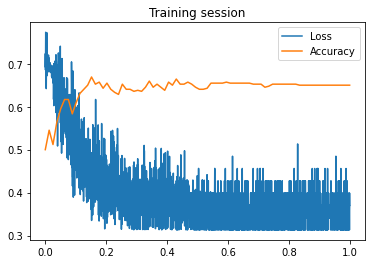

In [6]:
from torch.utils.data import DataLoader
import torch.optim as optim
from tqdm import tqdm

# Define criterion and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Train for n epochs
n = 80
test_while_training = True

loss_history = []
eval_history = []
count = 0
net.train()
for epoch in tqdm(range(n)):
    for i, data in enumerate(train_dataloader, 0):
        features, labels = data

        # Zero gradients
        optimizer.zero_grad()
        #net.zero_grad()

        # Forward
        predictions = net(features.float())
        
        # Compute loss
        loss = criterion(predictions, labels.long())
        loss_history.append(loss.item())
        
        # Backward
        loss.backward()
        
        # Optimize
        optimizer.step()
        
        count += 1
        
    # Evaluate the model against the test dataset
    if test_while_training:
        total = 0
        correct = 0
        with torch.no_grad():
            for i, data in enumerate(test_dataloader, 0):
                features, labels = data
                out = net(features.float())
                preds = F.log_softmax(out, dim=1).argmax(dim=1)
                total += labels.size(0)
                correct += (preds == labels).sum().item()

        eval_history.append(correct / total)

%matplotlib inline
plt.title("Training session")
print("Passes per epoch:", count / n)
print("Final Loss:", loss_history[-1])
plt.plot(np.linspace(0, 1, len(loss_history)), loss_history, label="Loss")
if test_while_training:
    print(f"Final Accuracy: {int(100*eval_history[-1])}%")
    plt.plot(np.linspace(0, 1, len(eval_history)), eval_history, label="Accuracy")
plt.legend()
plt.show()

In [7]:
net.eval()
total = 0
correct = 0
with torch.no_grad():
    for i, data in enumerate(test_dataloader, 0):
        features, labels = data
        out = net(features.float())
        preds = F.log_softmax(out, dim=1).argmax(dim=1)
        total += labels.size(0)
        correct += (preds == labels).sum().item()

model_accuracy = int(correct / total * 100)
print("Correct:", correct, "/", total, "-", f"{model_accuracy}%")

Correct: 273 / 420 - 65%


## Save the Model

In [8]:
from datetime import datetime

timestamp = str(datetime.now())
torch.save(net.state_dict(), f"../models/{timestamp}-Muse_EEG_eyes_open-{model_accuracy}percent.pt")
with open(f"../models/{timestamp}-Muse_EEG_eyes_open-{model_accuracy}percent.model", "w") as f:
    f.write(str(net))

RuntimeError: File ../models/2023-03-02 09:35:45.025256-Muse_EEG_eyes_open-65percent.pt cannot be opened.

## Raw EEG + FFT Model

While our previous model had an impressive accuracy given the size of our dataset, it can probably be improved by adding more features. We will provide outputs from a Fast Fourier Transform as additional features, banded over the primary brainwave bands - `Alpha`, `Beta`, `Theta`, `Delta`, `Gamma` (possibly split into `HighGamma` and `LowGamma`).

## Live Test

In [14]:
# TODO
muse2_recorder = Muse2EEGRecorder()
muse2_recorder.connect()
with torch.no_grad():
    for samples in muse2_recorder.stream(timedelta(seconds=5)):
        samples = np.expand_dims(samples[:, :4].T, axis=0)
        net(torch.from_numpy(samples).float())

Successfully connected to muse device
Muse 2 Sample rate: 256
Muse 2 time correction: -2.214987762272358e-05


RuntimeError: mat1 and mat2 shapes cannot be multiplied (1x1792 and 1696x512)